### An introduction to ipython notebooks

This notebook provides a crash-course overview of the basic capabilities and use of the MAF python interface. 
Please see our further tutorials for more in-depth examples.

To use this notebook, you need a version of MAF >= 2.4.2. Please see the instructions at https://confluence.lsstcorp.org/display/SIM/Catalogs+and+MAF for installing MAF. If you want to use the bleeding-edge 'master' version of MAF from the github repo, please install MAF and its dependencies using the instructions on that page first, and then follow the instructions further down in the "Mixing Installed Stack with Development Repositories" section. 

To run this notebook you should have,

> setup sims_maf -t sims

within the terminal where you ran jupyter notebook, i.e.

>jupyter notebook Introduction\ Notebook.ipynb

In this directory you should have downloaded the survey simulation database 

>wget http://astro-lsst-01.astro.washington.edu:8081/astro-lsst-01_2022.db

In [3]:
# Check the version of MAF - the output should be version 2.4.2 or higher.
# ('unknown' means you're running from a git repo version, and have made changes to your local code)
import lsst.sims.maf
lsst.sims.maf.__version__

'unknown'

In [4]:
# import matplotlib to show plots inline.
%matplotlib inline   
import matplotlib.pyplot as plt

Import the sims_maf modules needed.

In [5]:
# import our python modules
import lsst.sims.maf.db as db
import lsst.sims.maf.metrics as metrics
import lsst.sims.maf.slicers as slicers
import lsst.sims.maf.stackers as stackers
import lsst.sims.maf.plots as plots
import lsst.sims.maf.metricBundles as metricBundles

### Defining what we will measure and output

A `MetricBundle` combines a particular [`Metric`](https://confluence.lsstcorp.org/display/SIM/MAF+Metrics), a [`Slicer`](https://confluence.lsstcorp.org/display/SIM/MAF+Slicers), and a SQL constraint (constraint). 
- a `metric` calculates some quantity that you want to measure (e.g. the mean value of an attribute such as the airmass). 
- a `slicer` takes the list of visits from a simulated survey and orders or groups them (e.g. by night or by region on the sky).
- a constraint applies a SQL selection to the visits you want to select from the simulated survey database (such as 'filter = "r"')

Think of these as the building blocks of MAF grammar. What do you want to measure (metric) on what kind of basis function (slicer) on what subset of the data (constraint)? 

Some more examples: 
- coadded depth at each point in the sky in r band == 'Coaddm5Metric' + 'HealpixSlicer' + 'filter = "r"'
- median airmass at each point in the sky in i band == 'MedianMetric(col="airmass")' + 'HealpixSlicer' + 'filter = "i"'
- number of visits in each night == 'CountMetric()' + 'OneDSlicer(col='night')' + None
- median skybrightness of all visits in u band = 'MedianMetric(col='skybrightness')' + 'UniSlicer' + 'filter = "u"'

These examples will make more sense after we go through the examples and demonstrate the particular slicers, but hopefully that gives you the basic idea of the match between `metric`, `slicer` and `constraint` and "what you want to measure". The combination of these three things into "what you want to measure" makes a `MetricBundle`. 

After a `MetricBundle` has been run it stores the metric values calculated at each point of the slice data. You can also add additional provenance/metadata information to a given MetricBundle, in the form of the (opsim) runName and a metadata comment. This information will be used to generate output filenames and plot labels. Basically, a `MetricBundle` completely defines a particular measurement on the OpSim simulated survey.


Here is an example of generating a `MetricBundle`, calculating the maximum airmass value at each point of the sky in all bands.

In [6]:
# metric = the "maximum" of the "airmass" for each group of visits in the slicer
metric1 = metrics.MaxMetric('airmass')

# slicer = a grouping or subdivision of visits for the simulated survey based on their position on the sky 
# (using a Healpix grid)
slicer1 = slicers.HealpixSlicer(nside=64)

# sqlconstraint = the sql query (or 'select') that selects all visits in r band.
sqlconstraint= 'filter = "r"'

# MetricBundle = combination of the metric, slicer, and sqlconstraint
maxairmassSky = metricBundles.MetricBundle(metric1, slicer1, sqlconstraint)

Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


### Choosing the simulated survey database and the directory to output the results
The input data is queried from a database (usually a SQLite database).
The outputs are tracked in another database ('resultsDb_sqlite.db') in the results directory 'outDir'

In [7]:
# Note the V3 for opening opsim version 3.x databases. Use V4 for more recent runs.
opsdb = db.OpsimDatabase('astro-lsst-01_2022.db')
outDir = 'output_directory'
resultsDb = db.ResultsDb(outDir=outDir)

We can combine multiple MetricBundles and run them all at once to calculate their metric values, by combining them into a dictionary and sending this dictionary into a `MetricBundleGroup`. For now we will use calculate the metricvalues for our single 'maxairmassSky' MetricBundle. 

In [9]:
bundleDict = {'maxairmassSky': maxairmassSky}

We generate the outputs by combining the bundle dictionary with the input database and output directories and database, then using the `MetricBundleGroup` class.

The MetricBundleGroup will query the data from the opsim database and calculate the metric values, using the 'runAll' method. Note that MAF determines what columns you need from the database for your metrics and slicers, and only queries for those. MAF calculates the metrics in an efficient manner, caching results where possible and iterating through each slicer only once for all related metrics and saves everything to disk. 

In [10]:
group = metricBundles.MetricBundleGroup(bundleDict, opsdb, outDir=outDir, resultsDb=resultsDb)
group.runAll()

Querying database SummaryAllProps with constraint filter = "r" for columns ['fieldDec', 'fieldRA', 'airmass']
Found 515172 visits
Running:  ['maxairmassSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.


### Visualizing the output
We can now visualize the results of running these metrics. With a HealpixSlicer, the default is to generate 3 plots:
- the maximum airmass as a function of position on the sky (in a Healpix projection)
- a histogram of the airmass distribution for the pixels in the Healpix projection
- the angular powerspectrum of the maximum airmass

Plotting figures with "filter = "r"" constraint now.
monopole: 1.47182  dipole: lon: -8.14466, lat: 76.5121, amp: 0.310082
Plotting complete.


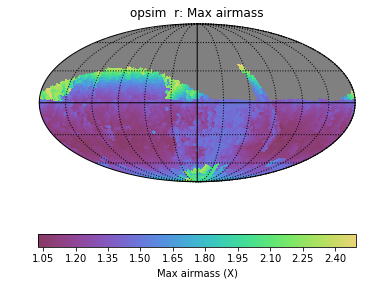

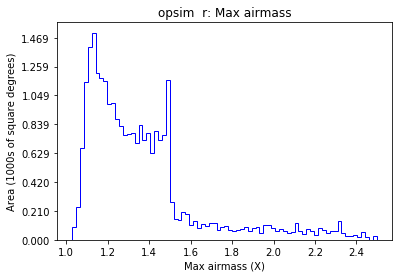

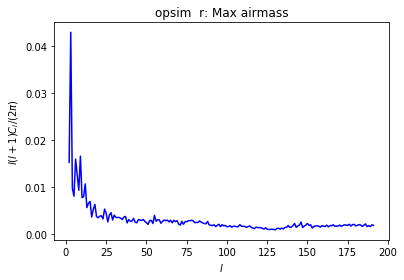

In [11]:
group.plotAll(closefigs=False)

### Extending the analysis: adding more metrics and more information

We create a new `MetricBundle` (nvisitsSky), that works with the same slicer and sql constraint but now counts the number of visits at each point in the healpix grid. To do this we use the 'CountMetric' to count the number of exposure MJD's in each Healpix pixel 

In [12]:
metric2 = metrics.CountMetric('observationStartMJD')
nvisitsSky = metricBundles.MetricBundle(metric2, slicer1, sqlconstraint)

We can also add ["summary metrics"](https://confluence.lsstcorp.org/display/SIM/MAF+Summary+Statistics) to each MetricBundle. These metrics  generate statistical summaries of the metric data values (e.g. the means of the number of visits per point on the sky).

In [13]:
summaryMetrics = [metrics.MinMetric(), metrics.MedianMetric(), metrics.MaxMetric(), metrics.RmsMetric()]
maxairmassSky.setSummaryMetrics(summaryMetrics)
nvisitsSky.setSummaryMetrics(summaryMetrics)

We can use the same metric but change the slicer (in this case grouping the visits by night) so we plot the maximum airmass and the number of visits per night)

In [14]:
# A slicer that will calculate a metric after grouping the visits into subsets corresponding to each night.
slicer2 = slicers.OneDSlicer(sliceColName='night', binsize=1, binMin=0, binMax=365*10)

# We can combine these slicers and metrics and generate more metricBundles
nvisitsPerNight = metricBundles.MetricBundle(metric1, slicer2, sqlconstraint, summaryMetrics=summaryMetrics)
maxairmassPerNight = metricBundles.MetricBundle(metric2, slicer2, sqlconstraint, summaryMetrics=summaryMetrics)

### Grouping everything together 
We can group any metricBundles together into a dictionary, and pass this to the MetricBundleGroup, which will run them (efficiently) together. 

In [15]:
bundleDict = {'maxairmassSky':maxairmassSky, 'maxairmassPerNight':maxairmassPerNight, 
        'nvisitsSky':nvisitsSky, 'nvisitsPerNight':nvisitsPerNight}

Querying database SummaryAllProps with constraint filter = "r" for columns ['night', 'observationStartMJD', 'fieldRA', 'airmass', 'fieldDec']
Found 515172 visits
Running:  ['maxairmassSky', 'nvisitsSky']
Completed metric generation.
Running:  ['maxairmassPerNight', 'nvisitsPerNight']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Plotting figures with "filter = "r"" constraint now.
monopole: 1.47182  dipole: lon: -8.14466, lat: 76.5121, amp: 0.310082


/Users/lynnej/lsstRepos/sims_maf/python/lsst/sims/maf/utils/mafUtils.py:60: UserWarning: Optimal bin calculation tried to make 562 bins, returning 200
  warnings.warn('Optimal bin calculation tried to make %.0f bins, returning %i'%(nbins, nbinMax))


monopole: 182.985  dipole: lon: -121.511, lat: -78.3775, amp: 21.2465
Plotting complete.


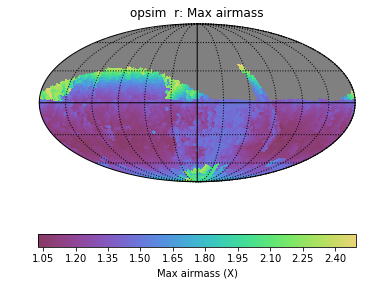

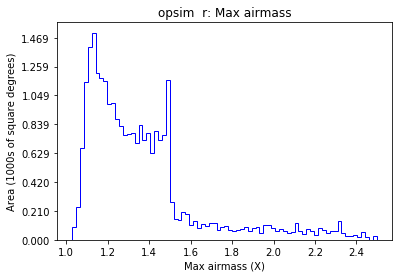

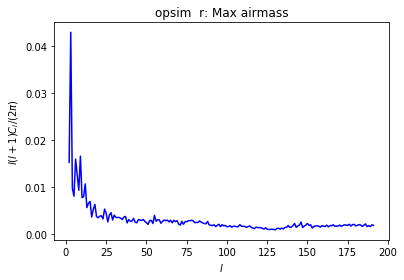

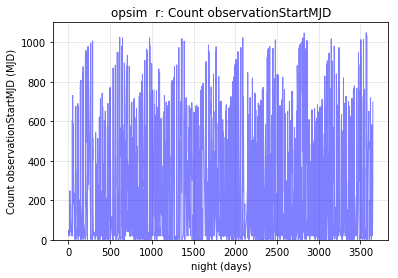

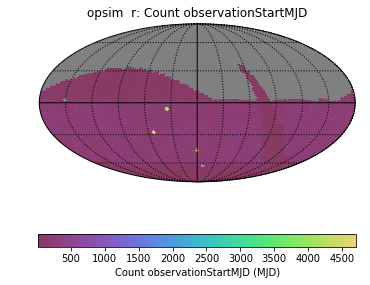

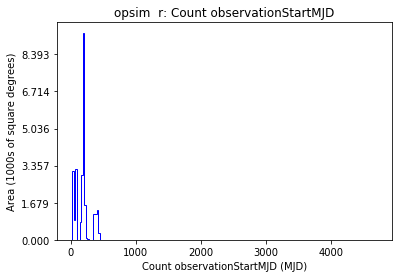

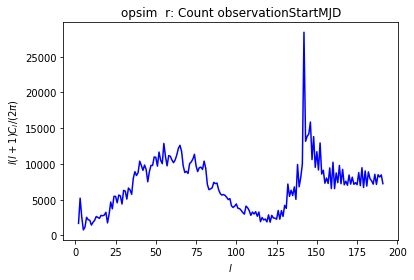

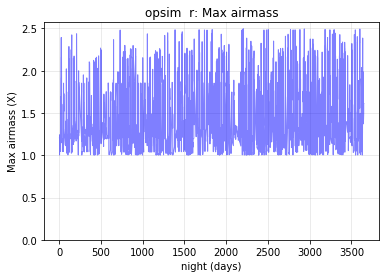

In [16]:
group = metricBundles.MetricBundleGroup(bundleDict, opsdb, outDir=outDir, resultsDb=resultsDb)
group.runAll()
group.plotAll(closefigs=False)

### Accessing the data generated by a metric

The results of the metric calculation are stored as an attribute in each metricbundle, as 'metricValues' - a numpy masked array. The results of the summary statistics are also stored in each metricbundle, in an attribute called 'summaryValues', which is a dictionary of the summarymetric name and value. 

For nvisitsSky, the metricValues are an array of the number of visits on the sky for each healpix pixel and the summaryValues are the mean, median etc of the these values

In [17]:
print("Array with the number of visits per pixel:", nvisitsSky.metricValues)

Array with the number of visits per pixel: [-- -- -- ..., 25.0 25.0 51.0]


The values of the metricValues above are shown as '--' because these happen to be values which are masked. There were no opsim visits for the healpix points which correspond to the values shown from the array. However, there actually is data in the numpy MaskedArray, and this can be seen by doing any of the "normal" numpy operations:

In [18]:
import numpy as np
np.max(nvisitsSky.metricValues)

4705.0

In [19]:
print("Summary of the max, median, min, and rms of the number of visits per pixel", nvisitsSky.summaryValues)

Summary of the max, median, min, and rms of the number of visits per pixel {'Min': 21.0, 'Median': 189.0, 'Max': 4705.0, 'Rms': 191.37177393301928}


---
### Hands-on example ###

To get you started with a hands-on example: try setting up a metric and slicer to calculate the mean single visit depth at each point across the sky in the 'i' band.   

You might find the documentation on the column names in the [opsim summary table](https://confluence.lsstcorp.org/display/SIM/Summary+Table+Column+Descriptions) useful, but the single visit depth column is called "fiveSigmaDepth'. 
Try not to peak at the final cell until you're done. :) 

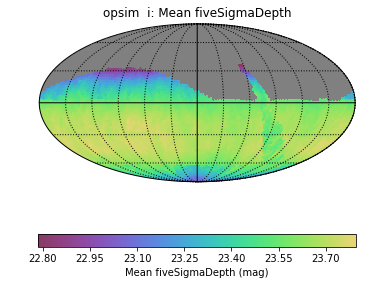

In [24]:
# This is what the skymap should look like:
from IPython.display import Image
Image(filename='images/thumb.opsim_Mean_fiveSigmaDepth_i_HEAL_SkyMap.png')

Healpix slicer using NSIDE=128, approximate resolution 27.483891 arcminutes
Querying database SummaryAllProps with constraint filter = "i" for columns ['fieldDec', 'fieldRA', 'fiveSigmaDepth']
Found 514481 visits
Running:  ['depth']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.


{'SkyMap': 1}

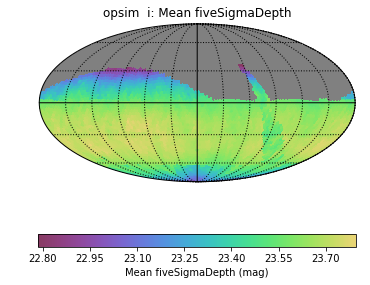

In [22]:
m = metrics.MeanMetric('fiveSigmaDepth')
s = slicers.HealpixSlicer()
constraint = 'filter = "i"'
mb = metricBundles.MetricBundle(m, s, constraint)
mg = metricBundles.MetricBundleGroup({'depth': mb}, opsdb)
mg.runAll()
mb.plot(plotFunc=plots.HealpixSkyMap(), savefig=True)